# Projects for Analysis of Anti-Depressant Drugs’s Adverse Events by FDA Adverse Event Reporting System (FAERS) from January 2019 to December 2023

## 5. ML MODELS

### 5.1 Load data & libraries

In [1]:
!pip install pandas scikit-learn transformers matplotlib
!pip install xgboost datasets tf-keras scipy

In [2]:
# load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Clinical BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

/opt/anaconda3/envs/mbd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load data
data = pd.read_csv('FAERS_mapped_data.csv')

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118577 entries, 0 to 118576
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   primaryid      118577 non-null  int64  
 1   role_cod       118577 non-null  object 
 2   prod_ai        118577 non-null  object 
 3   indi_pt        118577 non-null  object 
 4   event_dt       118577 non-null  object 
 5   age            118577 non-null  float64
 6   age_grp        118577 non-null  object 
 7   gender         118577 non-null  object 
 8   occr_country   118577 non-null  object 
 9   pt             118577 non-null  object 
 10  outc_cod       118577 non-null  object 
 11  prod_ai_group  118577 non-null  object 
 12  drug_cate      118577 non-null  object 
 13  ae_cate        118577 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 12.7+ MB
None
   primaryid         role_cod        prod_ai             indi_pt    event_dt  \
0   74189024  primar

In [4]:
# for better training and focused on antidepressants drugs
# => filter out drug_cate not antidepressants, then drop cols unneccessary col
data = data[data['drug_cate'] == 'antidepressants'].drop(columns=['role_cod', 'age_grp', 'drug_cate'])
data.head(10)

# # save the cleaned data for further analysis
# step5_data = data.copy()
# step5_data.to_csv('FAERS_data_models.csv', index=False)

,primaryid,prod_ai,indi_pt,event_dt,age,gender,occr_country,pt,outc_cod,prod_ai_group,ae_cate
0,74189024,sertraline,depressive symptom,2023-10-26,29.0,female,portugal,movement disorder,hospitalisation,selective serotonin reuptake inhibitors,nervous system disorders
1,74189024,sertraline,depressive symptom,2023-10-26,29.0,female,portugal,tremor,hospitalisation,selective serotonin reuptake inhibitors,nervous system disorders
2,74189024,sertraline,depressive symptom,2023-10-26,29.0,female,portugal,conversion disorder,hospitalisation,selective serotonin reuptake inhibitors,psychiatric disorders
3,74189024,sertraline,depressive symptom,2023-10-26,29.0,female,portugal,torticollis,hospitalisation,selective serotonin reuptake inhibitors,musculoskeletal and connective tissue disorders
14,122104123,duloxetine,depression,2023-12-07,63.0,female,united states,hyponatraemia,life threatening,serotonin and norepinephrine reuptake inhibitors,metabolism and nutrition disorders
15,122104123,duloxetine,depression,2023-12-07,63.0,female,united states,inappropriate antidiuretic hormone secretion,life threatening,serotonin and norepinephrine reuptake inhibitors,others
16,122104123,duloxetine,depression,2023-12-07,63.0,female,united states,coma,life threatening,serotonin and norepinephrine reuptake inhibitors,nervous system disorders
17,122104123,duloxetine,depression,2023-12-07,63.0,female,united states,hyponatraemic encephalopathy,life threatening,serotonin and norepinephrine reuptake inhibitors,nervous system disorders
18,122104123,duloxetine,depression,2023-12-07,63.0,female,united states,seizure,life threatening,serotonin and norepinephrine reuptake inhibitors,nervous system disorders
19,122104123,duloxetine,depression,2023-12-07,63.0,female,united states,generalised tonicclonic seizure,life threatening,serotonin and norepinephrine reuptake inhibitors,nervous system disorders


### 5.2 Prepare data

In [5]:
# reload data
data = pd.read_csv('FAERS_data_models.csv')

data['event_dt'] = pd.to_datetime(data['event_dt'], errors='coerce')

print(data.info())
print(data.columns)
print(data.head(10).T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108763 entries, 0 to 108762
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   primaryid      108763 non-null  int64         
 1   prod_ai        108763 non-null  object        
 2   indi_pt        108763 non-null  object        
 3   event_dt       108763 non-null  datetime64[ns]
 4   age            108763 non-null  float64       
 5   gender         108763 non-null  object        
 6   occr_country   108763 non-null  object        
 7   pt             108763 non-null  object        
 8   outc_cod       108763 non-null  object        
 9   prod_ai_group  108763 non-null  object        
 10  ae_cate        108763 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 9.1+ MB
None
Index(['primaryid', 'prod_ai', 'indi_pt', 'event_dt', 'age', 'gender',
       'occr_country', 'pt', 'outc_cod', 'prod_ai_group'

In [6]:
# since the adverse events might relevant to covid => extract year for further analysis
data['event_year'] = data['event_dt'].dt.year

def categorize_year(year):
    if year <= 2019:
        return 'Pre-COVID'
    elif year >= 2022:
        return 'Post-COVID'
    else:
        return 'Covid'

data['event_period'] = data['event_year'].apply(categorize_year)

le_event_period = LabelEncoder()
data['event_period_encoded'] = le_event_period.fit_transform(data['event_period'])

In [7]:
# seperate features and target

# Features
X = data[['prod_ai', 'indi_pt', 'age', 'gender', 'occr_country', 'pt', 'outc_cod', 'prod_ai_group', 'event_year', 'event_period_encoded']].copy()

# Target
y = data['ae_cate'].copy()

In [8]:
# encode target w value between 0 and n_classes-1
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [9]:
# encode cate vars
categorical_features = ['gender', 'occr_country', 'outc_cod', 'prod_ai_group', 'event_period_encoded']

le_dict = {}

for col in categorical_features:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])
    le_dict[col] = le  # Save the encoder for inverse transformation if needed

In [10]:
# text features & drop after finished
text_features = ['pt', 'prod_ai', 'indi_pt']

# Combine text features into a single feature
X['text_combined'] = X['pt'] + ' ' + X['prod_ai'] + ' ' + X['indi_pt']

X = X.drop(columns=['pt', 'prod_ai', 'indi_pt'])

### 5.3 Split data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=2711, stratify=y_encoded
)

### 5.4 Logistic Regression with TF-IDF

In [12]:
# create preprocess
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define which columns are text, numeric, or categorical
text_feature = 'text_combined'
numeric_features = ['age', 'event_year']
categorical_features = ['gender', 'occr_country', 'outc_cod', 'prod_ai_group', 'event_period_encoded']

# Define transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english'), text_feature),
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [13]:
# create pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Create the pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])

In [14]:
# perform 5-CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []
conf_matrices = []
roc_auc_scores = []

for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    
    pipeline_lr.fit(X_tr, y_tr)
    y_pred = pipeline_lr.predict(X_val)
    y_proba = pipeline_lr.predict_proba(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    acc_scores.append(accuracy)

    f1 = f1_score(y_val, y_pred, average='macro')
    f1_scores.append(f1)
    
    cm = confusion_matrix(y_val, y_pred)
    conf_matrices.append(cm)
    
    # Compute ROC AUC score for each class and take the average
    roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
    roc_auc_scores.append(roc_auc)

print("Train LR - Accuracy Score:", np.mean(acc_scores))
print("Train LR - Average F1 Score:", np.mean(f1_scores))
print("Train LR - Average ROC AUC Score:", np.mean(roc_auc_scores))


Train LR - Accuracy Score: 0.9729111596368233
Train LR - Average F1 Score: 0.9650767576451228
Train LR - Average ROC AUC Score: 0.9982894614899713


In [15]:
# evaluate test set

# Fit on full training data
pipeline_lr.fit(X_train, y_train)

# Predict on test data
y_pred_lr = pipeline_lr.predict(X_test)
y_proba_lr = pipeline_lr.predict_proba(X_test)

# Metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
cm_lr = confusion_matrix(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr, multi_class='ovr')

print("Test LR - Accuracy Score:", acc_lr)
print("Test LR - F1 Score:", f1_lr)
print("Test LR - ROC AUC Score:", roc_auc_lr)

Test LR - Accuracy Score: 0.9755895738518825
Test LR - F1 Score: 0.969349706409154
Test LR - ROC AUC Score: 0.9988507288812377


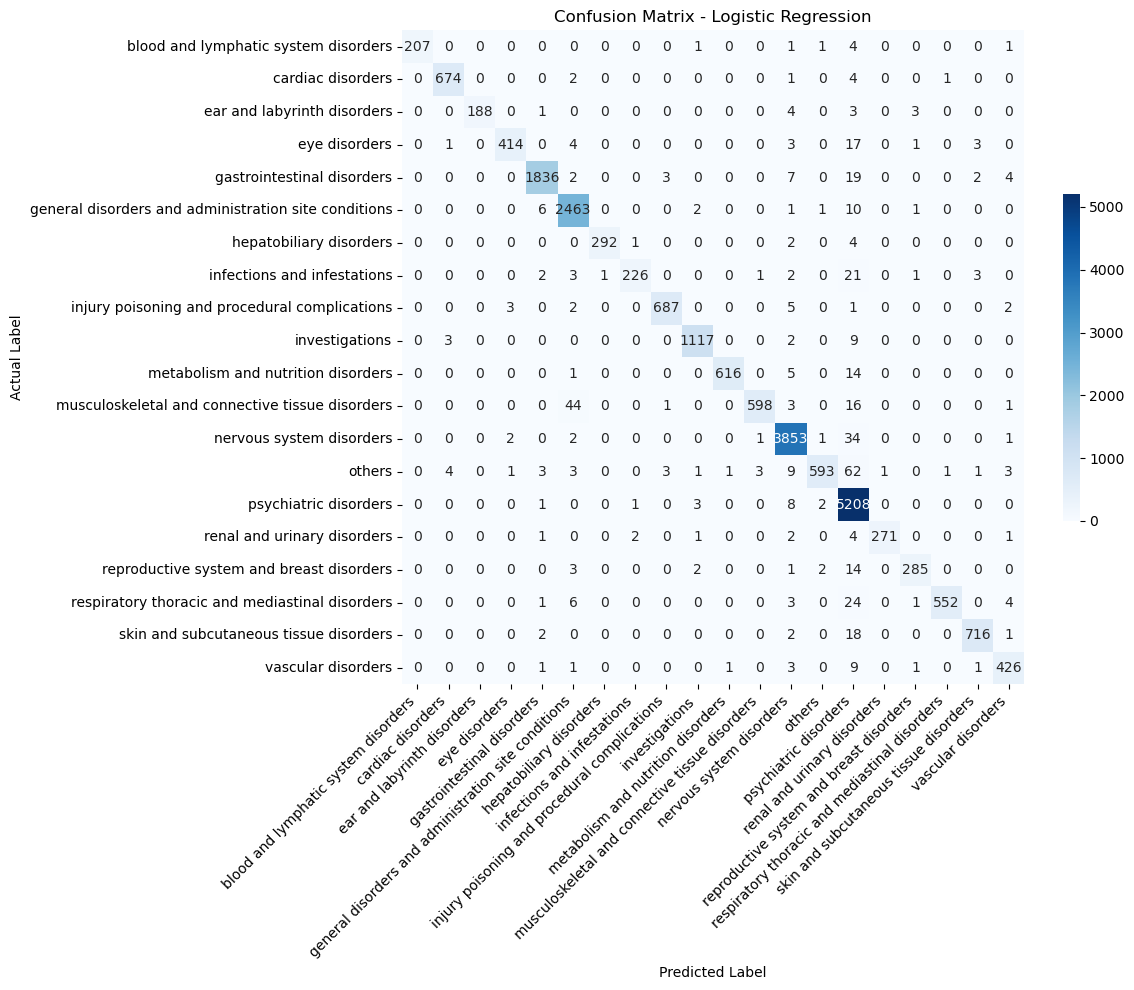

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have the confusion matrix 'cm_test' and the label encoder 'le_target'

# Get the class labels from the LabelEncoder
class_labels = le_target.classes_

# Create a DataFrame for the confusion matrix for better visualization
cm_lr_df = pd.DataFrame(cm_lr, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_lr_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .5})
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Weighted-Averaged ROC AUC Score: 0.9992569551255533


/var/folders/_z/wx40qqws337c64bjr5v3vh_80000gn/T/ipykernel_65514/1744067325.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


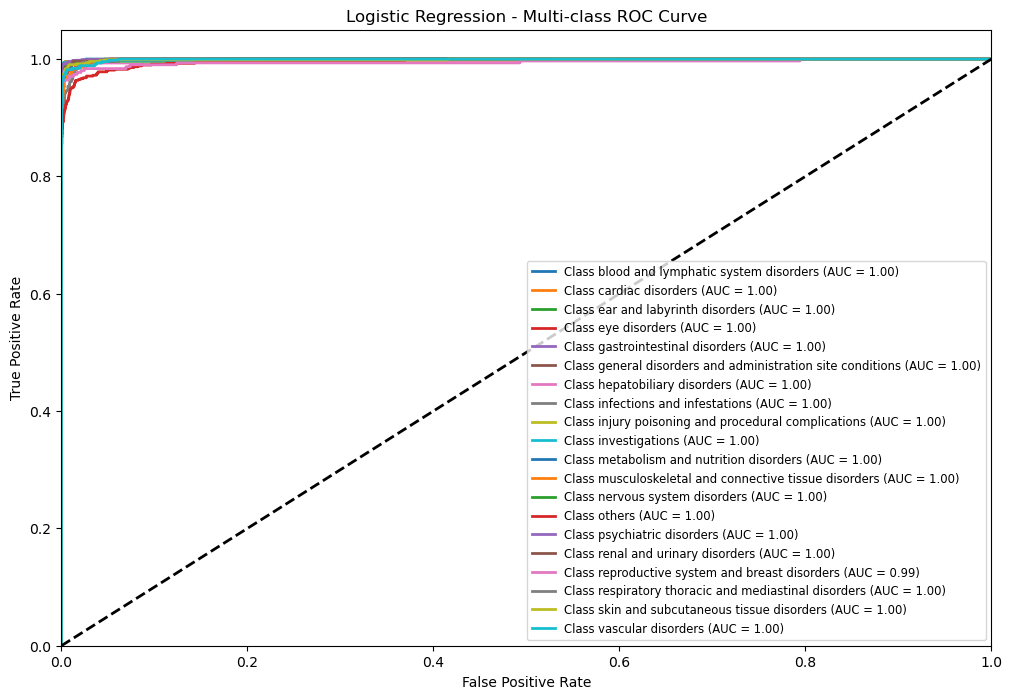

In [17]:
# Import necessary functions
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Number of classes
n_classes = len(le_target.classes_)

# Binarize the test labels
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Predicted probabilities
y_score_lr = y_proba_lr

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()

# Compute FPR, TPR, and ROC AUC for each class
for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_binarized[:, i], y_score_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

# Compute the overall ROC AUC score using weighted averaging
roc_auc_weighted_lr = roc_auc_score(y_test_binarized, y_score_lr, average='weighted', multi_class='ovr')

print("Weighted-Averaged ROC AUC Score:", roc_auc_weighted_lr)

# Plot ROC curves for all classes
plt.figure(figsize=(12, 8))

colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr_lr[i], tpr_lr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(le_target.classes_[i], roc_auc_lr[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - Multi-class ROC Curve')
plt.legend(loc="lower right", fontsize='small')
plt.show()

### 5.5 SVC with TF-IDF

In [18]:
# create pipeline for SVM
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# Create the pipeline with LinearSVC
base_classifier = LinearSVC(class_weight='balanced', dual='auto', C=1.0, max_iter=5000)
classifier = CalibratedClassifierCV(base_classifier)  # Wrap with calibration for probabilities

pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [19]:
# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'classifier__estimator__C': uniform(0.1, 10),
    'preprocessor__tfidf__max_features': [1000, 3000],
    'preprocessor__tfidf__ngram_range': [(1, 1), (1, 2)]
}

In [20]:
# Perform 5-fold cross-validation with hyperparameter tuning
random_search = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=2711
)

In [21]:
# Fit the model on the training data
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END classifier__estimator__C=1.110076170497959, preprocessor__tfidf__max_features=1000, preprocessor__tfidf__ngram_range=(1, 1); total time= 1.3min
[CV] END classifier__estimator__C=1.110076170497959, preprocessor__tfidf__max_features=1000, preprocessor__tfidf__ngram_range=(1, 1); total time= 1.3min
[CV] END classifier__estimator__C=3.1302336740582812, preprocessor__tfidf__max_features=3000, preprocessor__tfidf__ngram_range=(1, 1); total time= 1.5min
[CV] END classifier__estimator__C=3.1302336740582812, preprocessor__tfidf__max_features=3000, preprocessor__tfidf__ngram_range=(1, 1); total time= 1.5min
[CV] END classifier__estimator__C=3.1302336740582812, preprocessor__tfidf__max_features=3000, preprocessor__tfidf__ngram_range=(1, 1); total time= 1.5min
[CV] END classifier__estimator__C=6.925618291773016, preprocessor__tfidf__max_features=1000, preprocessor__tfidf__ngram_range=(1, 2); total time= 1.9min
[CV] END classifier

In [22]:
# Evaluate on test set using the best model
best_model_svc = random_search.best_estimator_

# Predict on test data
y_pred_svc = best_model_svc.predict(X_test)
y_proba_svc = best_model_svc.predict_proba(X_test)


In [23]:
# Metrics
acc_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='macro')
cm_svc = confusion_matrix(y_test, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test, y_proba_svc, multi_class='ovr')

print("Test SVM - Accuracy Score:", acc_svc)
print("Test SVM - F1 Score:", f1_svc)
print("Test SVM - ROC AUC Score:", roc_auc_svc)

Test SVM - Accuracy Score: 0.9947593435388222
Test SVM - F1 Score: 0.9929984116915916
Test SVM - ROC AUC Score: 0.9985532792623548


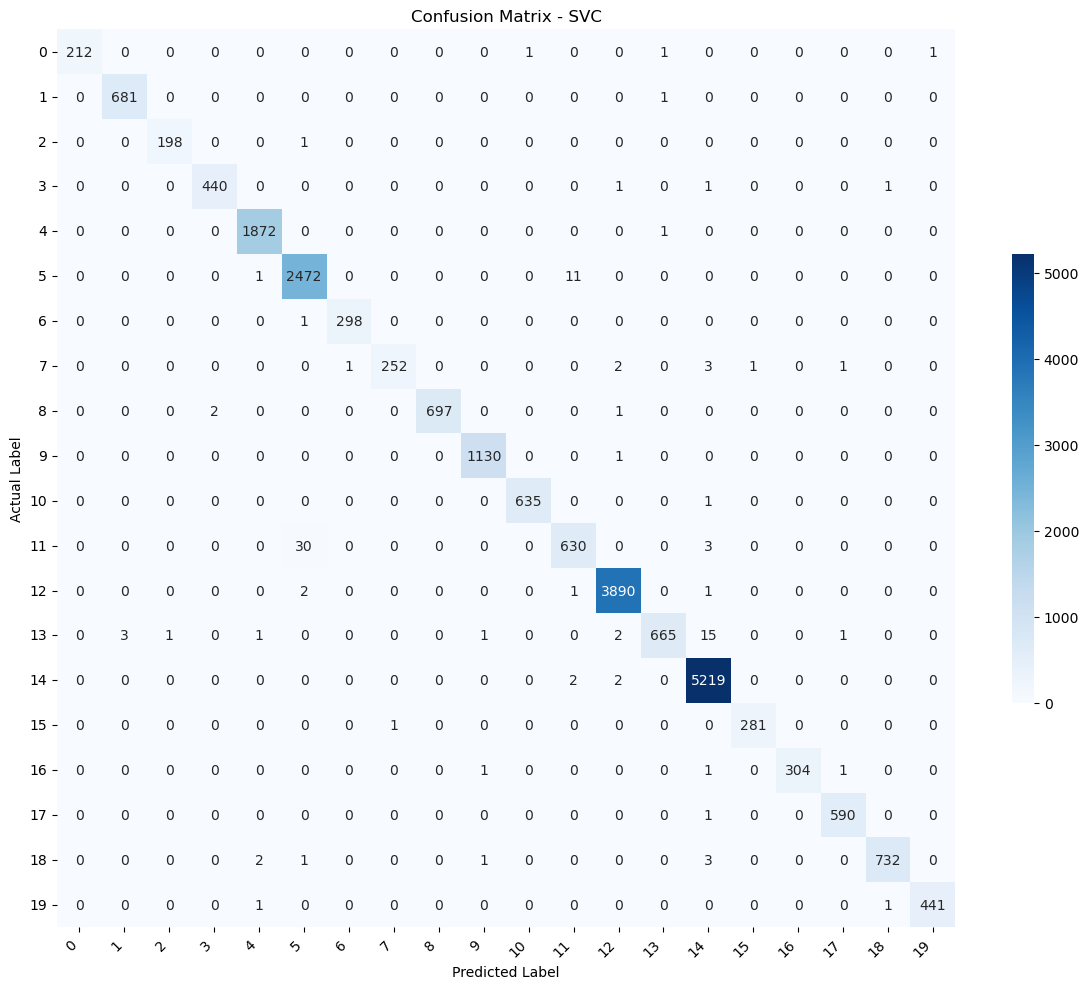

In [24]:
# Plot confusion matrix
class_labels = np.unique(y_test)  # Assuming y_test is already label encoded

cm_svc_df = pd.DataFrame(cm_svc, index=class_labels, columns=class_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_svc_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .5})
plt.title('Confusion Matrix - SVC')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Weighted-Averaged ROC AUC Score: 0.99910907857937


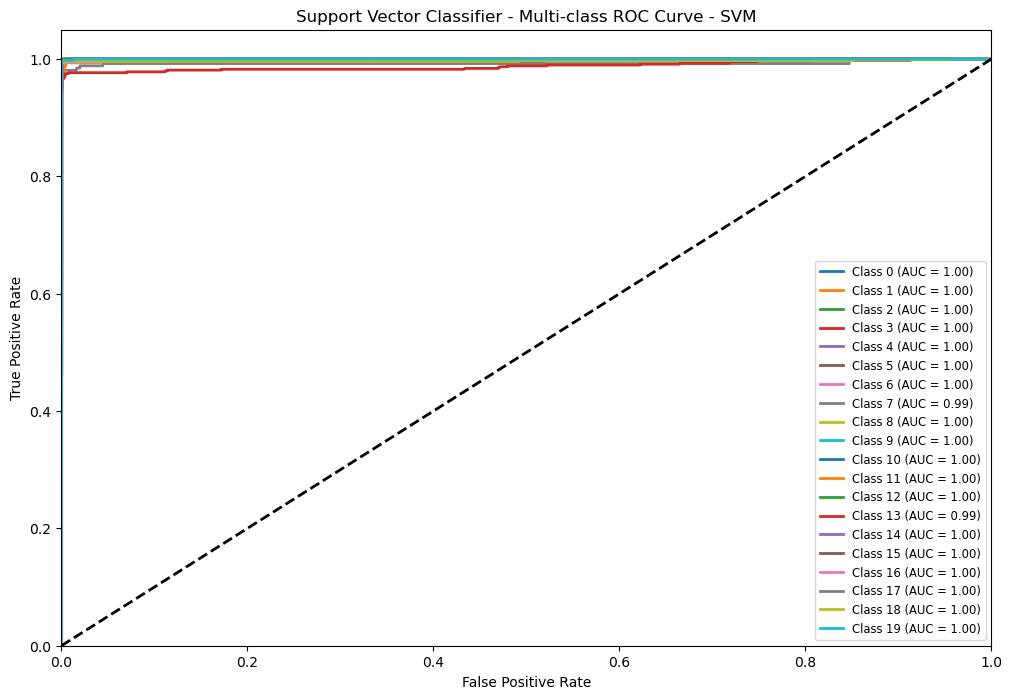

In [25]:
# Plot ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Number of classes
n_classes = len(np.unique(y_test))

# Binarize the test labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Predicted probabilities
y_score_svc = y_proba_svc

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

# Compute FPR, TPR, and ROC AUC for each class
for i in range(n_classes):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_binarized[:, i], y_score_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

# Compute the overall ROC AUC score using weighted averaging
roc_auc_weighted_svc = roc_auc_score(y_test_binarized, y_score_svc, average='weighted', multi_class='ovr')

print("Weighted-Averaged ROC AUC Score:", roc_auc_weighted_svc)

# Plot ROC curves for all classes
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr_svc[i], tpr_svc[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(class_labels[i], roc_auc_svc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Classifier - Multi-class ROC Curve - SVM')
plt.legend(loc="lower right", fontsize='small')
plt.show()

### 5.6 Clinical-BERT model

In [26]:
!pip install transformers

In [27]:
import torch
torch.cuda.empty_cache()

In [28]:
# include covid for text label
X_train['event_period_text'] = le_event_period.inverse_transform(X_train['event_period_encoded'])
X_test['event_period_text'] = le_event_period.inverse_transform(X_test['event_period_encoded'])

# Combine text data with event period
X_train['text_combined_with_date'] = X_train['text_combined'] + ' ' + X_train['event_period_text']
X_test['text_combined_with_date'] = X_test['text_combined'] + ' ' + X_test['event_period_text']

In [29]:
# preapre data w texts & labels
from torch.utils.data import Dataset

class AE_Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [30]:
# tokenise
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [31]:
# data set load
from torch.utils.data import DataLoader

MAX_LEN = 8
BATCH_SIZE = 4

train_dataset = AE_Dataset(
    texts=X_train['text_combined_with_date'].tolist(),
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = AE_Dataset(
    texts=X_test['text_combined_with_date'].tolist(),
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [32]:
# create model
from transformers import AutoModelForSequenceClassification

n_classes = len(le_target.classes_)

model = AutoModelForSequenceClassification.from_pretrained(
    'emilyalsentzer/Bio_ClinicalBERT', num_labels=n_classes
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# define training
from transformers import TrainingArguments

# Freezing the first 8 transformer layers
for param in model.bert.encoder.layer[:10].parameters():
    param.requires_grad = False

training_args = TrainingArguments(
    output_dir='./results',
    seed=2711,
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    gradient_accumulation_steps=4,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=2000,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,
    max_grad_norm=1.0,
    report_to='tensorboard'
)

/opt/anaconda3/envs/mbd/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
# define metrics
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    f1 = f1_score(labels, preds, average='macro')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1
    }

In [35]:
# create trainer
from transformers import Trainer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding
import math

# optimzer & scheduler fine-tuning
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

steps_per_epoch = math.ceil(len(train_dataset) / training_args.per_device_train_batch_size)
total_steps = steps_per_epoch * training_args.num_train_epochs
num_warmup_steps = int(training_args.warmup_ratio * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps
)

# create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

In [36]:
# train model - don't rerun if unneccsary ~ est 1.5 hrs
trainer.train()

 12%|█▏        | 2000/16314 [49:22<2:20:49,  1.69it/s]   

{'loss': 2.6819, 'grad_norm': 17.57921028137207, 'learning_rate': 1.532567049808429e-05, 'epoch': 0.37}


 25%|██▍       | 4000/16314 [1:12:12<3:37:07,  1.06s/it]

{'loss': 2.181, 'grad_norm': 39.05763244628906, 'learning_rate': 3.065134099616858e-05, 'epoch': 0.74}


                                                        
 33%|███▎      | 5438/16314 [1:37:16<2:25:25,  1.25it/s]

{'eval_loss': 1.0344749689102173, 'eval_accuracy': 0.7036730565898957, 'eval_f1': 0.3219224751598532, 'eval_runtime': 526.1753, 'eval_samples_per_second': 41.342, 'eval_steps_per_second': 10.337, 'epoch': 1.0}


 37%|███▋      | 6000/16314 [2:03:36<53:33,  3.21it/s]     

{'loss': 1.3749, 'grad_norm': 34.12990188598633, 'learning_rate': 4.597701149425287e-05, 'epoch': 1.1}


 49%|████▉     | 8000/16314 [2:22:49<2:09:49,  1.07it/s]

{'loss': 0.6036, 'grad_norm': 48.22832489013672, 'learning_rate': 4.874433888378112e-05, 'epoch': 1.47}


 61%|██████▏   | 10000/16314 [2:47:37<1:05:04,  1.62it/s]

{'loss': 0.2611, 'grad_norm': 1.840024471282959, 'learning_rate': 4.704174753975551e-05, 'epoch': 1.84}


                                                         
 67%|██████▋   | 10876/16314 [3:04:43<1:00:41,  1.49it/s]

{'eval_loss': 0.11610893160104752, 'eval_accuracy': 0.973750747023399, 'eval_f1': 0.9527652094704997, 'eval_runtime': 351.3384, 'eval_samples_per_second': 61.915, 'eval_steps_per_second': 15.481, 'epoch': 2.0}


 74%|███████▎  | 12000/16314 [4:03:47<23:13,  3.10it/s]     

{'loss': 0.1456, 'grad_norm': 1.588366985321045, 'learning_rate': 4.53391561957299e-05, 'epoch': 2.21}


 86%|████████▌ | 14000/16314 [4:19:04<26:40,  1.45it/s]

{'loss': 0.1014, 'grad_norm': 59.86680221557617, 'learning_rate': 4.3636564851704296e-05, 'epoch': 2.57}


 98%|█████████▊| 16000/16314 [4:29:33<01:37,  3.22it/s]

{'loss': 0.0823, 'grad_norm': 0.6059978604316711, 'learning_rate': 4.1933973507678685e-05, 'epoch': 2.94}


                                                       
100%|██████████| 16314/16314 [4:49:20<00:00,  3.19it/s]

{'eval_loss': 0.07342911511659622, 'eval_accuracy': 0.9857950627499655, 'eval_f1': 0.9743329391382411, 'eval_runtime': 1087.7753, 'eval_samples_per_second': 19.998, 'eval_steps_per_second': 5.0, 'epoch': 3.0}


100%|██████████| 16314/16314 [4:49:22<00:00,  1.06s/it]

{'train_runtime': 17362.1798, 'train_samples_per_second': 15.034, 'train_steps_per_second': 0.94, 'train_loss': 0.9125142267584231, 'epoch': 3.0}


TrainOutput(global_step=16314, training_loss=0.9125142267584231, metrics={'train_runtime': 17362.1798, 'train_samples_per_second': 15.034, 'train_steps_per_second': 0.94, 'total_flos': 1073255420709120.0, 'train_loss': 0.9125142267584231, 'epoch': 2.9998620879878635})

In [37]:
# evaluate model
eval_result = trainer.evaluate()
print(eval_result)

100%|██████████| 5439/5439 [02:39<00:00, 34.14it/s]

{'eval_loss': 0.07342911511659622, 'eval_accuracy': 0.9857950627499655, 'eval_f1': 0.9743329391382411, 'eval_runtime': 159.3857, 'eval_samples_per_second': 136.48, 'eval_steps_per_second': 34.125, 'epoch': 2.9998620879878635}


In [38]:
# Get predictions
predictions, labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis=1)

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

acc_bert = accuracy_score(labels, preds)
f1_bert = f1_score(labels, preds, average='macro')
cm_bert = confusion_matrix(labels, preds)

# For ROC AUC
from sklearn.preprocessing import label_binarize

# Number of classes
n_classes = len(le_target.classes_)

# Binarize the true labels
labels_binarized = label_binarize(labels, classes=range(n_classes))

# Predicted probabilities from Clinical BERT
probs = predictions  # These are logits; we'll apply softmax

import torch

probs = torch.nn.functional.softmax(torch.tensor(probs), dim=1).numpy()

roc_auc_bert = roc_auc_score(labels_binarized, probs, average='weighted', multi_class='ovr')

print("Clinical BERT Test Accuracy:", acc_bert)
print("Clinical BERT Test F1 Score:", f1_bert)
print("Clinical BERT ROC AUC Score:", roc_auc_bert)

100%|██████████| 5439/5439 [02:47<00:00, 32.44it/s]


Clinical BERT Test Accuracy: 0.9857950627499655
Clinical BERT Test F1 Score: 0.9743329391382411
Clinical BERT ROC AUC Score: 0.9995297509904394


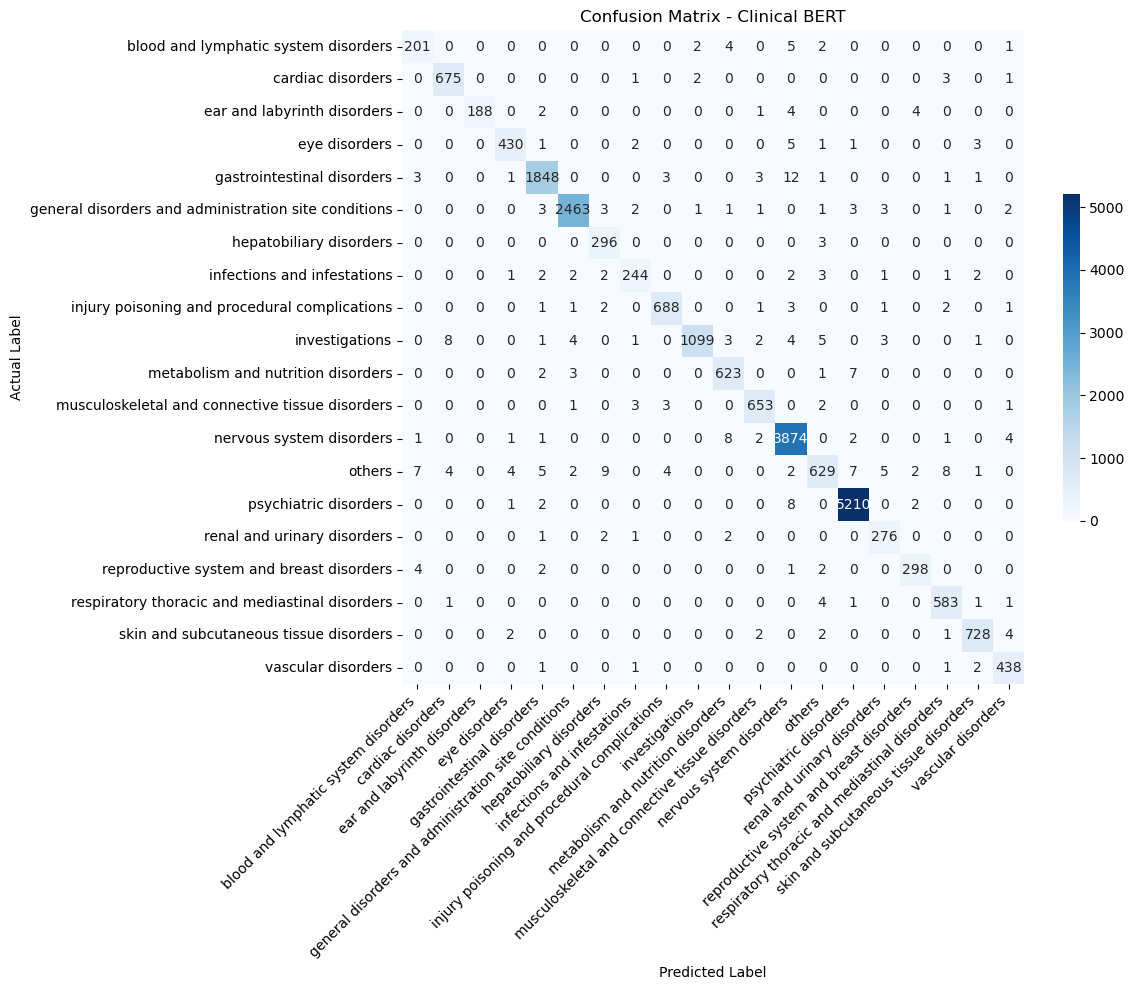

In [39]:
# plot confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the class labels from the LabelEncoder
class_labels = le_target.classes_

# Create a DataFrame for the confusion matrix for better visualization
cm_bert_df = pd.DataFrame(cm_bert, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_bert_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .5})
plt.title('Confusion Matrix - Clinical BERT')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Weighted-Averaged ROC AUC Score: 0.9995297509904394


/var/folders/_z/wx40qqws337c64bjr5v3vh_80000gn/T/ipykernel_65514/342257774.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


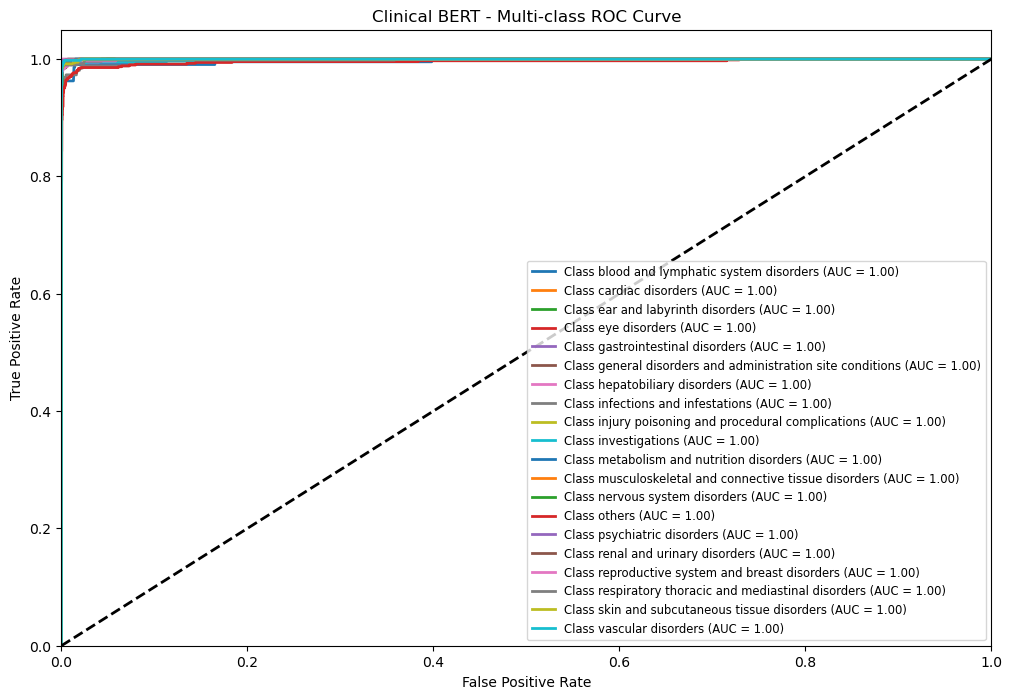

In [40]:
# plot roc curve
from sklearn.metrics import roc_curve, auc

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr_bert = dict()
tpr_bert = dict()
roc_auc_bert = dict()

# Compute FPR, TPR, and ROC AUC for each class
for i in range(n_classes):
    fpr_bert[i], tpr_bert[i], _ = roc_curve(labels_binarized[:, i], probs[:, i])
    roc_auc_bert[i] = auc(fpr_bert[i], tpr_bert[i])

# Compute the overall ROC AUC score using weighted averaging
roc_auc_weighted_bert = roc_auc_score(labels_binarized, probs, average='weighted', multi_class='ovr')

print("Weighted-Averaged ROC AUC Score:", roc_auc_weighted_bert)

# Plot ROC curves for all classes
plt.figure(figsize=(12, 8))

colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr_bert[i], tpr_bert[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(class_labels[i], roc_auc_bert[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Clinical BERT - Multi-class ROC Curve')
plt.legend(loc="lower right", fontsize='small')
plt.show()


### 5.7 Performance comparison

In [44]:
# compile results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVC', 'Clinical BERT'],
    'Accuracy': [acc_lr, acc_svc, acc_bert],
    'F1 Score': [f1_lr, f1_svc, f1_bert]
})

print(results)

                 Model  Accuracy  F1 Score
0  Logistic Regression  0.975590  0.969350
1                  SVC  0.994759  0.992998
2        Clinical BERT  0.985795  0.974333


> Refer fda_step6_topic for Topic modelling.